# DECISION TREE

1. Gini Index.
2. Create Split.
3. Build a Tree.
4. Make a Prediction.
5. Banknote Case Study

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from random import seed
from random import randrange
import csv

In [2]:
filename = "data_banknote_authentication.csv"

In [3]:
def loadCsv(path):
    lines = csv.reader(open(path))
    dataset = list(lines)
    for i in range(len(dataset)):
        dataset[i] = [float(x) for x in dataset[i]]
    return dataset

### 1. Gini Impurity and split point

In [4]:
# Calculate the Gini impurity for a split dataset
def calGiniImpurity(groups, classes):
    """
    gini impurity = (sum((1 - sum[(p_class_i^2) for i :=0 to (n-1)])  
                     / (weight of class at split point=nInstance/totalInstace))
                    )
    item_g_ij = [value, class]
    groups = [
        [item_g00, item_g01, ...],
        [item_g10, item_g11, ...],
    ]
    classes = [class_0, class_1, ../]
    """
    # count all samples at split point
    nInstances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # print(group, size)
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for classVal in classes:
            # print(classVal)
            p = [row[-1] for row in group].count(classVal) / size
            score += p * p
            # print("Score:", score)
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / nInstances)
    return gini

In [5]:
# test Gini values
print(calGiniImpurity(
    [
        [[1, 1], [1, 0]], # Class 0
        [[1, 1], [1, 0]], # Class 1
    ], 
    [0, 1])
     )
print(calGiniImpurity(
    [
        [[1, 0], [1, 0]], # Class 0
        [[1, 1], [1, 1]], # Class 1
    ], 
    [0, 1])
     )

0.5
0.0


In [6]:
def splitDataset(index, splitVal, dataset):
    left, right = [], []
    for row in dataset:
        if row[index] < splitVal:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [7]:
# Select the best split point for a dataset
def getBestSplit(dataset):
    classValues = list(set(row[-1] for row in dataset))
    bIndex, bValue, bScore, bGroups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = splitDataset(index, row[index], dataset)
            gini = calGiniImpurity(groups, classValues)
            # print('X%d < %.3f Gini=%.3f' % ((index+1), row[index], gini))
            if gini < bScore:
                bIndex, bValue, bScore, bGroups = index, row[index], gini, groups
    return {'index':bIndex, 'value':bValue, 'groups':bGroups}

In [8]:
dataset = [
    [2.771244718,1.784783929,0],
    [1.728571309,1.169761413,0],
    [3.678319846,2.81281357,0],
    [3.961043357,2.61995032,0],
    [2.999208922,2.209014212,0],
    [7.497545867,3.162953546,1],
    [9.00220326,3.339047188,1],
    [7.444542326,0.476683375,1],
    [10.12493903,3.234550982,1],
    [6.642287351,3.319983761,1]
]

In [9]:
X0 = [c[0] for c in dataset if c[2]==0]
Y0 = [c[1] for c in dataset if c[2]==0]
X1 = [c[0] for c in dataset if c[2]==1]
Y1 = [c[1] for c in dataset if c[2]==1]

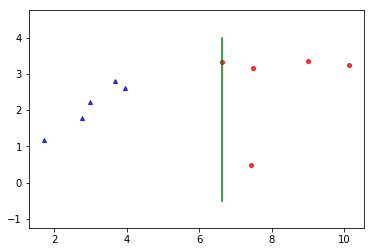

In [10]:
plt.plot(X0, Y0, "b^", markersize = 4, alpha = .8)
plt.plot(X1, Y1, "ro", markersize = 4, alpha = .8)
xSplit = [6.64] * 100
ySplit = np.linspace(-0.5, 4, 100)
plt.plot(xSplit, ySplit, "-g")
plt.axis('equal')
plt.show()

In [11]:
split = getBestSplit(dataset)
print('Split: [X%d < %.3f]' % ((split['index']+1), split['value']))

Split: [X1 < 6.642]


### 2. Build the tree

In [12]:
# Create a terminal node value
# Defined by max depth and minimum samples per nodes
def toTerminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

In [13]:
# Create child splits for a node or make terminal
def split(node, maxDepth, minSize, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = toTerminal(left + right)
        return
    # check for max depth
    if depth >= maxDepth:
        node['left'], node['right'] = toTerminal(left), toTerminal(right)
        return
    # process left child
    if len(left) <= minSize:
        node['left'] = toTerminal(left)
    else:
        node['left'] = getBestSplit(left)
        split(node['left'], maxDepth, minSize, depth+1)
    # process right child
    if len(right) <= minSize:
        node['right'] = toTerminal(right)
    else:
        node['right'] = getBestSplit(right)
        split(node['right'], maxDepth, minSize, depth+1)

In [14]:
# Build a decision tree
def buildTree(train, maxDepth, minSize):
    root = getBestSplit(train)
    split(root, maxDepth, minSize, 1)
    return root

In [15]:
# Print a decision tree
def printTree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        printTree(node['left'], depth+1)
        printTree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))


In [16]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [17]:
#  predict with a stump
stump = {'index': 0, 'right': 1, 'value': 6.642287351, 'left': 0}
for row in dataset:
    prediction = predict(stump, row)
    print('Expected=%d, Got=%d' % (row[-1], prediction))


Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=0, Got=0
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1
Expected=1, Got=1


In [18]:
# Classification and Regression Tree Algorithm
def fit(train, maxDepth, minSize):
    tree = buildTree(train, maxDepth, minSize)
    return tree

def decisionTree(train, test, maxDepth, minSize):
    tree = buildTree(train, maxDepth, minSize)
    predictions = list()
    for row in test:
        prediction = predict(tree, row)
        predictions.append(prediction)
    return(predictions)

# Split a dataset into k folds
def crossValidationSplit(dataset, nFolds):
    datasetSplit = list()
    datasetCopy = list(dataset)
    foldSize = int(len(dataset) / nFolds)
    for i in range(nFolds):
        fold = list()
        while len(fold) < foldSize:
            index = randrange(len(datasetCopy))
            fold.append(datasetCopy.pop(index))
        datasetSplit.append(fold)
    return datasetSplit

# Calculate accuracy percentage
def accuracyMetric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0


# Evaluate an algorithm using a cross validation split
def evaluateAlgorithm(dataset, algorithm, nFolds, *args):
    folds = crossValidationSplit(dataset, nFolds)
    scores = list()
    for fold in folds:
        trainSet = list(folds)
        trainSet.remove(fold)
        trainSet = sum(trainSet, [])
        testSet = list()
        for row in fold:
            rowCopy = list(row)
            testSet.append(rowCopy)
            rowCopy[-1] = None
        predicted = algorithm(trainSet, testSet, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracyMetric(actual, predicted)
        scores.append(accuracy)
    return scores

### 3. Test the algorithm

In [19]:
# Test CART on Bank Note dataset
seed(1)
# load and prepare data
filename = "data_banknote_authentication.csv"
dataset = loadCsv(filename)

In [20]:
# evaluate algorithm
nFolds = 5
maxDepth = 5
minSize = 10
scores = evaluateAlgorithm(dataset, decisionTree, nFolds, maxDepth, minSize)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [96.35036496350365, 97.08029197080292, 97.44525547445255, 98.17518248175182, 97.44525547445255]
Mean Accuracy: 97.299%


### 4. Validate by sklearn

In [21]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
lsFt = ["ft_%d"%i for i in range(4)] 
lsCol = lsFt + ["label"]

In [24]:
filename = 'data_banknote_authentication.csv'
pdfData = pd.read_csv(filename, names=lsCol)

In [25]:
pdfData.shape

(1372, 5)

In [26]:
pdfData.head()

,ft_0,ft_1,ft_2,ft_3,label
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


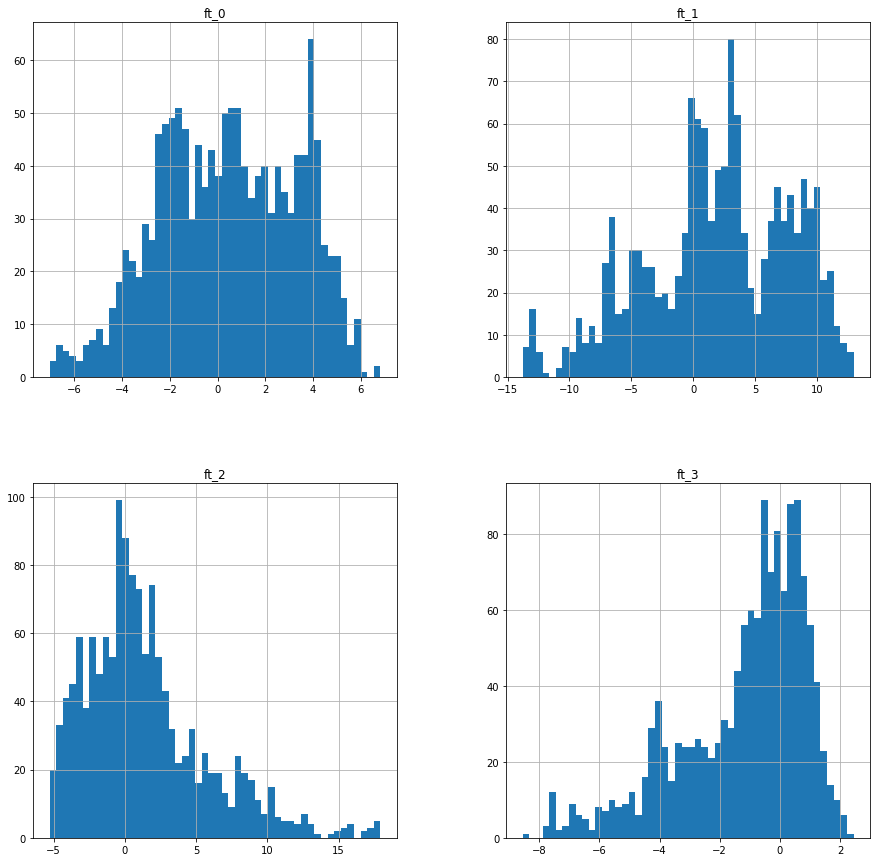

In [27]:
pdfData[lsFt].hist(bins=50, figsize=(15,15))
plt.show()

In [28]:
corrMatrix = pdfData.corr()
print(corrMatrix["label"].sort_values(ascending=False))

label    1.000000
ft_2     0.155883
ft_3    -0.023424
ft_1    -0.444688
ft_0    -0.724843
Name: label, dtype: float64


In [29]:
data = pdfData[lsFt].values
label = pdfData[["label"]].values

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    data, label, test_size=0.2, random_state=2)

In [31]:
dTreeClf = DecisionTreeClassifier()

In [32]:
# K-fold estimator, scoring="neg_mean_squared_error"
scores = cross_val_score(dTreeClf, X_train, y_train,
                         scoring="roc_auc", cv=5)
print(scores)

[0.98269489 0.97395833 0.96706989 0.99193548 0.98014549]


In [33]:
dTreeClf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [34]:
predictions = dTreeClf.predict(X_test)

[[139   4]
 [  1 131]]


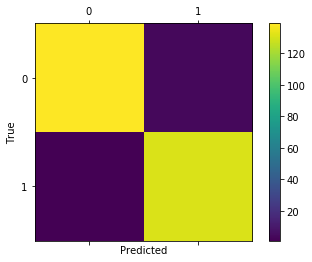

------------------------------


In [35]:
# creating a confusion matrix 
cm = confusion_matrix(y_test, predictions) 
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
# plt.title('Confusion matrix')
fig.colorbar(cax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
print("-"*30)

In [36]:
# Receiver Operating Characteristic (ROC) metric to evaluate classifier output quality
def drawROC(trueLabel, predictions):
    # fpr: false_positive_rate
    # tpr: true_positive_rate 
    # thres: thresholds 
    fpr, tpr, thres = roc_curve(trueLabel, predictions)
    aucScore = auc(fpr, tpr)
    plt.figure()
    lw = 2
    # Plot the curve
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % aucScore)

    # Plot the random line
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return 0

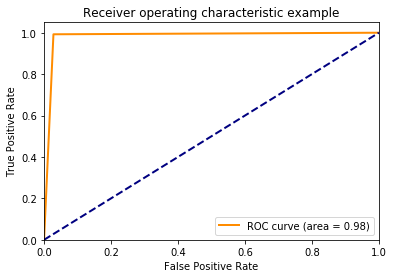

0

In [37]:
## Draw AUC curve
drawROC(y_test, predictions)